In [3]:
include("./KeplerSolver.jl")
include("./Doppler.jl")
using Doppler
using KeplerSolver
using PyPlot
using DataFrames
using LsqFit

/Users/tgordon/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
# get the radial velocity data

rv_data = readtable("mystery_planet1.txt", separator = ' ');
t = rv_data[1];
v = rv_data[2];
err = rv_data[3];
t = t - t[1];

In [5]:
# functions to fold radial velocity curve and to compute the sum of the differences between adjacent RV points

function fold(t, t0)
    t = t .% t0 
end

function adjacent_diffs(v)
    sum = 0
    for i in 1:length(v)
        j = i + 1
        if j > length(v)
            j = 1
        end
        sum = sum + abs(v[i] - v[j])
    end
    return sum
end;

In [6]:
# find the correct period to fold on

min = adjacent_diffs(v)
t0_min = 0
t_min = t[1]
t_max = t[length(t)]
for t0 in linspace(t_min, t_max, 10000)
    p = sortperm(fold(t, t0))
    diffs = adjacent_diffs(v[p])
    if diffs < min
        min = diffs
        t0_min = t0
    end
end 
folded_t = fold(t, t0_min);

In [7]:
# model of RV curve

function model(t, params)
    P, ecc, tp, gamma, omega, K = params
    return vrad(t, P, ecc, tp, gamma, omega, K)
end;

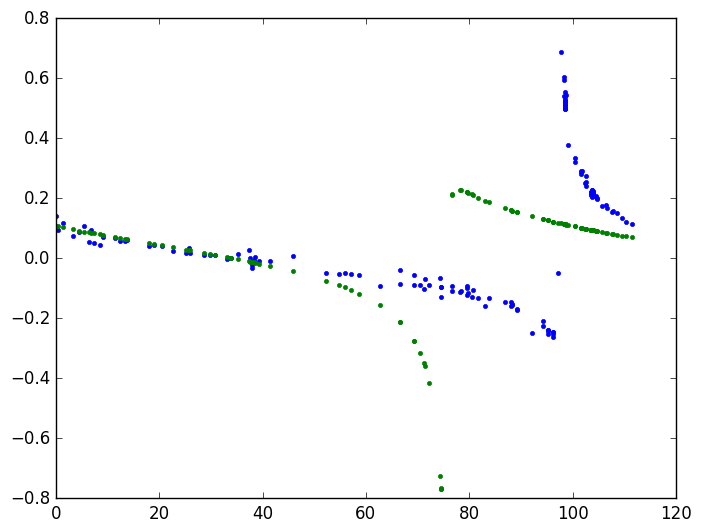

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31c8823d0>

In [8]:
# used this cell to guess initial parameters for LsqFit
 plot(folded_t, v, ".") 
 plot(folded_t, model(folded_t, [100,0.9,75,0,180, 0.5]), ".")

In [9]:
# fit using LsqFit

fit = curve_fit(model, convert(Array, folded_t), convert(Array, v), [100,0.9,75,0,180, 0.5]);

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in Optim.MultivariateOptimizationResults{T,N,M}(::String, ::Array{Float64,1}, ::Array{Float64,1}, ::Float64, ::Int64, ::Bool, ::Bool, ::Float64, ::Bool, ::Float64, ::Bool, ::Float64, ::Array{Optim.OptimizationState{LsqFit.LevenbergMarquardt},1}, ::Int64, ::Int64) at ./deprecated.jl:50
 in #levenberg_marquardt#1(::Float64, ::Float64, ::Int64, ::Float64, ::Bool, ::Array{Float64,1}, ::Array{Float64,1}, ::Function, ::LsqFit.#f#4{#model,Array{Float64,1},Array{Float64,1}}, ::Calculus.#g#5{LsqFit.#f#4{#model,Array{Float64,1},Array{Float64,1}},Symbol}, ::Array{Float64,1}) at /Users/tgordon/.julia/v0.5/LsqFit/src/levenberg_marquardt.jl:169
 in #lmfit#2(::Array{Any,1}, ::Function, ::LsqFit.#f#4{#model,Array{Float64,1},Array{Float64,1}}, ::Array{Float64,1}) at /Users/tgordon/.julia/v0.5/LsqFit/src/curve_fit.jl:29
 in #curve_fit#3(::Array{Any,1}, ::Function, ::#model, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}) at /Users/tgordo

params [P, ecc, tp, gamma, omega, K] = 

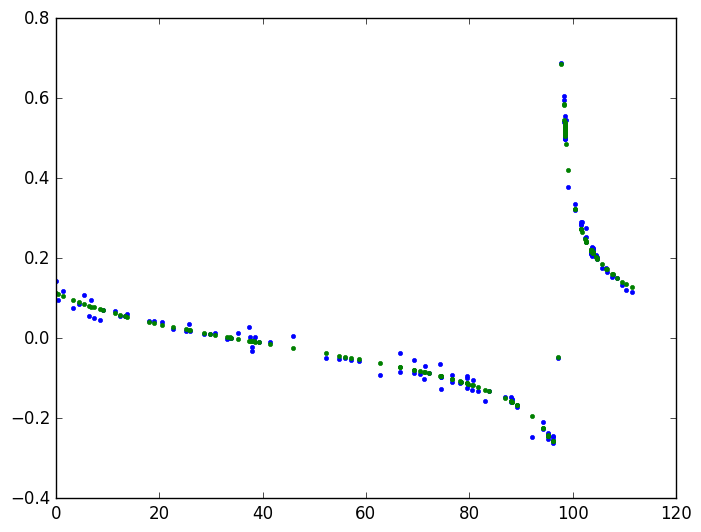

[113.547,0.936538,97.5303,0.00204711,181.151,0.477087]


In [10]:
# plot the fit and print the parameters

plot(folded_t, v, ".")
plot(folded_t, model(folded_t, fit.param), ".")
println("params [P, ecc, tp, gamma, omega, K] = ", fit.param)